In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Input, GaussianNoise, Dense, Reshape, Embedding, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/PSM1/fastaFile")

In [ ]:
input_list = ["atv.fasta", "ddi.fasta", "etr.fasta", "rpv.fasta", "drv.fasta", "tpv.fasta",
              "lpv.fasta", "sqv.fasta", "nfv.fasta", "fpv.fasta", "idv.fasta", "dft.fasta",
              "abc.fasta", "azt.fasta", "efv.fasta", "nvp.fasta", "tdf.fasta", "ttc.fasta"]

In [ ]:
def convert_to_int(sequence):
    char_to_int = {
        'A': 1, 'a': 1, 'B': 2, 'b': 2, 'C': 3, 'c': 3, 'D': 4, 'd': 4,
        'E': 5, 'e': 5, 'F': 6, 'f': 6, 'G': 7, 'g': 7, 'H': 8, 'h': 8,
        'I': 9, 'i': 9, 'J': 10, 'j': 10, 'K': 11, 'k': 11, 'L': 12, 'l': 12,
        'M': 13, 'm': 13, 'N': 14, 'n': 14, 'O': 15, 'o': 15, 'P': 16, 'p': 16,
        'Q': 17, 'q': 17, 'R': 18, 'r': 18, 'S': 19, 's': 19, 'T': 20, 't': 20,
        'U': 21, 'u': 21, 'V': 22, 'v': 22, 'W': 23, 'w': 23, 'X': 24, 'x': 24,
        'Y': 25, 'y': 25, 'Z': 26, 'z': 26, '.': 27, '#': 28, '~': 29, '*': 30
    }
    return [char_to_int.get(char, 0) for char in sequence]

In [ ]:
# Initialize arrays to store labels and sequences
data_labels = []
data_seqs = []

# Process each input file
for infile in input_list:
    index = input_list.index(infile) + 1
    genecode = "PR" if index in [1, 5, 6, 7, 8, 9, 10, 11] else "RT"

    if genecode == "RT":
        bp = 240
    elif genecode == "PR":
        bp = 99

    with open(infile, "r") as fasta_file:
        fasta_lines = fasta_file.readlines()

    fasta = [line.strip() for line in fasta_lines if line.strip()]

    # Use a set to track unique sequences
    unique_sequences = set()

    # Read fasta file and extract labels and sequences
    for i in range(0, len(fasta), 2):
        # Validate format
        if fasta[i].startswith('>') and len(fasta) > i + 1:
            seqID = fasta[i][1:]  # Remove '>' to get seqID
            seq = fasta[i + 1].strip()  # Strip newline and whitespace

            # Extract resistant class (0 or 1) from the last character of seqID
            try:
                resistant_class = int(seqID[-1])
            except ValueError:
                continue  # Skip if the resistant class is not an integer

            # Strip seqID to only keep the sequence label
            seq_label = seqID[:-1]

            # Check for duplicates
            if seq in unique_sequences:
                continue  # Skip duplicate sequences
            unique_sequences.add(seq)

            # Append to data_labels and data_seqs
            data_labels.append(resistant_class)
            data_seqs.append(seq)

# Convert lists to numpy arrays
data_labels = np.array(data_labels)
data_seqs = np.array(data_seqs)

# print("Data Labels (Resistant Class):", data_labels)
# print("\nData Sequences:")
# for label, seq in zip(data_labels, data_seqs):
#     print(f"Resistant Class: {label}, Sequence: {seq}")

In [ ]:
# Parameters
bp = 240  # Length of the sequences

# Initialize seqs_num array
seqs_num = np.zeros((len(data_seqs), bp), dtype=int)

# Convert sequences to integers
for i in range(len(data_seqs)):
    seq_int = convert_to_int(data_seqs[i])
    seqs_num[i, :len(seq_int)] = np.array(seq_int)

# Pad sequences to a maximum length of bp
data_f = pad_sequences(seqs_num, padding='post', maxlen=bp)

In [ ]:
data_f.shape

(19982, 240)

In [ ]:
# Set random seed for numpy
np.random.seed(1234)

In [ ]:
# Number of folds for cross-validation
k = 5

# Create k-fold cross-validation
kf = KFold(n_splits=k)
validation_scores = []

# Iterate through the k folds
for train_index, val_index in kf.split(data_f):
        # Separate validation and training data
        validation_data_k = data_f[val_index]
        validation_labels_k = data_labels[val_index]
        training_data = data_f[train_index]
        training_labels = data_labels[train_index]

In [ ]:
# Adjust generator model to produce sequences of length bp with regularization
def create_generator(latent_dim, bp, dropout_rate=0.3, l2_lambda=0.001):
    model = Sequential([
        Dense(256, input_dim=latent_dim, activation='relu', kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(512, activation='relu', kernel_regularizer=l2(l2_lambda)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(bp, activation='sigmoid', kernel_regularizer=l2(l2_lambda)),
        Reshape((bp,))
    ])
    return model

def create_discriminator(bp, dropout_rate=0.3, l2_lambda=0.001):
    model = Sequential([
        Flatten(input_shape=(bp,)),
        GaussianNoise(0.1),

        Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),

        Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),

        Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_lambda))
    ])
    return model

# Compile the GAN components and create the GAN model
def compile_gan(generator, discriminator):
    discriminator.compile(optimizer=Adam(learning_rate=0.002, beta_1=0.5), loss='binary_crossentropy')
    discriminator.trainable = False
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(learning_rate=0.002, beta_1=0.5), loss='binary_crossentropy')
    return gan

# Function to generate random noise (latent points)
def generate_latent_points(latent_dim, n_samples):
    return np.random.randn(n_samples, latent_dim)

# Function to generate synthetic data
def generate_synthetic_data(generator, latent_dim, n_samples):
    latent_points = generate_latent_points(latent_dim, n_samples)
    synthetic_data = generator.predict(latent_points)
    return synthetic_data

# Function to train the GAN with validation data and class weights
def train_gan(gan, generator, discriminator, training_data, training_labels, validation_data_k, validation_labels_k, latent_dim, n_epochs, batch_size, weight_real=1, weight_fake=1):
    half_batch = batch_size // 2
    d_losses_real = []
    d_losses_fake = []
    weighted_d_losses = []
    gan_losses = []

    for epoch in range(n_epochs):
        # Generate half_batch fake samples
        fake_samples = generate_synthetic_data(generator, latent_dim, half_batch)
        fake_labels = np.random.randint(0, 2, (half_batch, 1))  # Generate random labels: 0 or 1

        # Generate half_batch real samples
        real_indices = np.random.randint(0, training_data.shape[0], half_batch)
        real_samples = training_data[real_indices]
        real_labels = training_labels[real_indices]  # Use actual labels from training data

        # Calculate class weights
        zero = np.sum(training_labels == 0)
        one = np.sum(training_labels == 1)
        weight_0 = len(training_labels) / (2 * zero) if zero != 0 else 1
        weight_1 = len(training_labels) / (2 * one) if one != 0 else 1

        # Train the discriminator with class weights
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels, class_weight={0: weight_0, 1: weight_1})
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels, class_weight={0: weight_0, 1: weight_1})
        d_loss = weight_real * d_loss_real + weight_fake * d_loss_fake

        # Train the generator (via the combined GAN model)
        latent_points = generate_latent_points(latent_dim, batch_size)
        gan_loss = gan.train_on_batch(latent_points, np.ones((batch_size, 1)))

        # Collect losses for plotting
        d_losses_real.append(d_loss_real)
        d_losses_fake.append(d_loss_fake)
        weighted_d_losses.append(d_loss)
        gan_losses.append(gan_loss)

        # Print progress
        print(f"Epoch {epoch+1}/{n_epochs}, D Loss Real: {d_loss_real}, D Loss Fake: {d_loss_fake}, Weighted D Loss: {d_loss}, GAN Loss: {gan_loss}")

    return d_losses_real, d_losses_fake, weighted_d_losses, gan_losses

# Performance measure function
def perf_measure(y_ref, y_pred):
    TP = FP = TN = FN = 0
    for i in range(len(y_pred)):
        if y_ref[i] == 1 and y_pred[i] == 1:
            TP += 1
        elif y_ref[i] == 0 and y_pred[i] == 0:
            TN += 1
        elif y_ref[i] == 0 and y_pred[i] == 1:
            FP += 1
        elif y_ref[i] == 1 and y_pred[i] == 0:
            FN += 1
    return np.array([TP, FP, TN, FN])

# Function to calculate metrics
def calculate_metrics(TP, FP, TN, FN):
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) != 0 else 0
    return accuracy, sensitivity, specificity, f1_score

In [ ]:
# Define the dimensions of the latent space (input to the generator)
latent_dim = 200
n_epochs = 500
batch_size = 128

In [ ]:
# Create models
generator = create_generator(latent_dim, bp)
discriminator = create_discriminator(bp)
# Compile GAN
gan = compile_gan(generator, discriminator)

In [ ]:
# Training the GAN and collecting losses
d_losses_real, d_losses_fake, weighted_d_losses, gan_losses = train_gan(gan, generator, discriminator, training_data, training_labels, validation_data_k, validation_labels_k, latent_dim, n_epochs=n_epochs, batch_size=batch_size)

2/2 [==============================] - 0s 7ms/step
Epoch 1/500, D Loss Real: 7.631024360656738, D Loss Fake: 1.2472023963928223, Weighted D Loss: 8.87822675704956, GAN Loss: 2.5340206623077393
2/2 [==============================] - 0s 8ms/step
Epoch 2/500, D Loss Real: 7.221465587615967, D Loss Fake: 1.0440479516983032, Weighted D Loss: 8.26551353931427, GAN Loss: 1.8499490022659302
2/2 [==============================] - 0s 9ms/step
Epoch 3/500, D Loss Real: 4.675433158874512, D Loss Fake: 0.9793245196342468, Weighted D Loss: 5.6547576785087585, GAN Loss: 1.5442049503326416
2/2 [==============================] - 0s 8ms/step
Epoch 4/500, D Loss Real: 5.829328536987305, D Loss Fake: 0.985939621925354, Weighted D Loss: 6.815268158912659, GAN Loss: 1.7784641981124878
2/2 [==============================] - 0s 9ms/step
Epoch 5/500, D Loss Real: 2.3309764862060547, D Loss Fake: 1.0299965143203735, Weighted D Loss: 3.3609730005264282, GAN Loss: 1.7641621828079224
2/2 [=========================

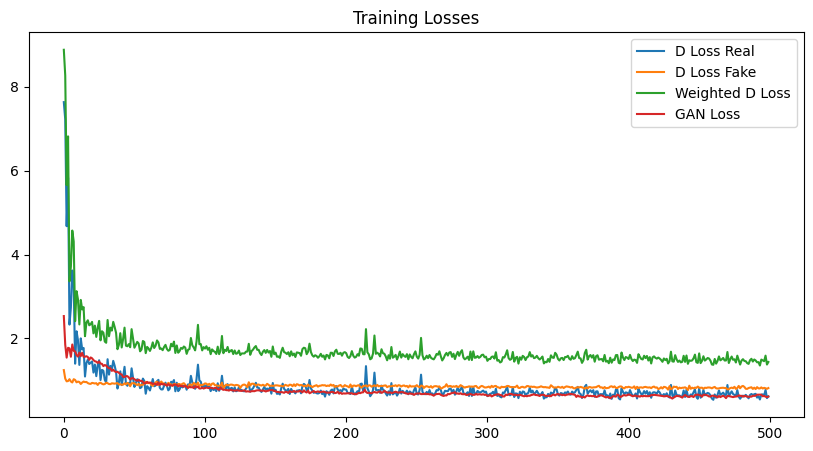

In [ ]:
# Plotting losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(d_losses_real, label='D Loss Real')
plt.plot(d_losses_fake, label='D Loss Fake')
plt.plot(weighted_d_losses, label='Weighted D Loss')
plt.plot(gan_losses, label='GAN Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

In [ ]:
# Generate synthetic data
n_synthetic_samples = len(training_data)  # Number of synthetic samples to generate
synthetic_data = generate_synthetic_data(generator, latent_dim, n_synthetic_samples)

500/500 [==============================] - 1s 2ms/step


In [ ]:
# Combine synthetic data with real data
combined_data = np.vstack((training_data, synthetic_data))
combined_labels = np.hstack((training_labels, np.ones(n_synthetic_samples)))  # Label synthetic data as 1 (or 0 depending on the context)

In [ ]:
combined_data.shape

(31972, 240)

In [ ]:
combined_labels.shape

(31972,)

In [ ]:
# Split combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_data, combined_labels, test_size=0.2, random_state=1234)

In [ ]:
# Reshape data for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
bp = X_train.shape[1]

In [ ]:
# Define the CNN model based on the provided R model structure
def get_model(bp):
    model = Sequential()
    model.add(Embedding(input_dim=bp, output_dim=128, input_length=bp))

    # First Convolutional Layer with L2 regularization
    model.add(Conv1D(32, kernel_size=9, activation='relu', input_shape=(bp, 1),
                     kernel_regularizer=l2(0.001)))
    model.add(MaxPooling1D(pool_size=5))
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting

    # Second Convolutional Layer with L2 regularization
    model.add(Conv1D(32, kernel_size=9, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Flatten())

    # Fully connected layer with Dropout
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting

     # Output layer
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Get the model
cnn_model = get_model(bp)

In [ ]:
# Train the CNN model
history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/100
400/400 [==============================] - 54s 132ms/step - loss: 0.3553 - accuracy: 0.8800 - val_loss: 0.2613 - val_accuracy: 0.9007
Epoch 2/100
400/400 [==============================] - 49s 124ms/step - loss: 0.2555 - accuracy: 0.9044 - val_loss: 0.2435 - val_accuracy: 0.8985
Epoch 3/100
400/400 [==============================] - 50s 125ms/step - loss: 0.2378 - accuracy: 0.9059 - val_loss: 0.2304 - val_accuracy: 0.9004
Epoch 4/100
400/400 [==============================] - 53s 132ms/step - loss: 0.2303 - accuracy: 0.9082 - val_loss: 0.2249 - val_accuracy: 0.9034
Epoch 5/100
400/400 [==============================] - 49s 124ms/step - loss: 0.2299 - accuracy: 0.9073 - val_loss: 0.2177 - val_accuracy: 0.9070
Epoch 6/100
400/400 [==============================] - 50s 125ms/step - loss: 0.2224 - accuracy: 0.9086 - val_loss: 0.2182 - val_accuracy: 0.9087
Epoch 7/100
400/400 [==============================] - 50s 125ms/step - loss: 0.2237 - accuracy: 0.9106 - val_loss: 0.2156 -

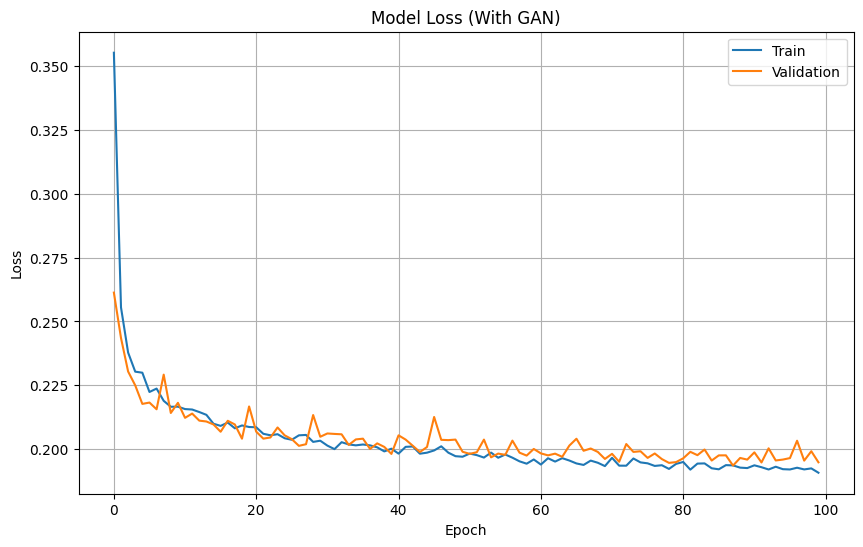

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (With GAN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the CNN model
y_pred = cnn_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

200/200 [==============================] - 3s 14ms/step


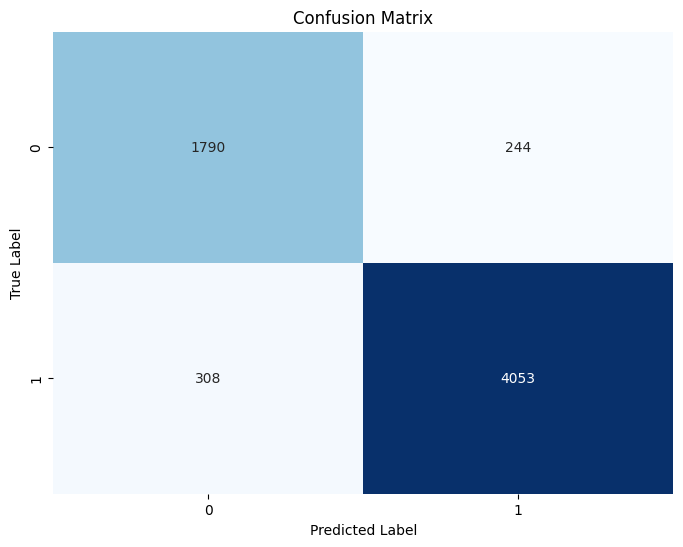

True Positives (TP): 4053
False Positives (FP): 244
True Negatives (TN): 1790
False Negatives (FN): 308


In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Extract TP, FP, TN, FN values from confusion matrix
TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)

In [ ]:
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9136825645035184
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87      2034
         1.0       0.94      0.93      0.94      4361

    accuracy                           0.91      6395
   macro avg       0.90      0.90      0.90      6395
weighted avg       0.91      0.91      0.91      6395



In [ ]:
# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print(f'AUC: {auc}')

AUC: 0.9047066640782462


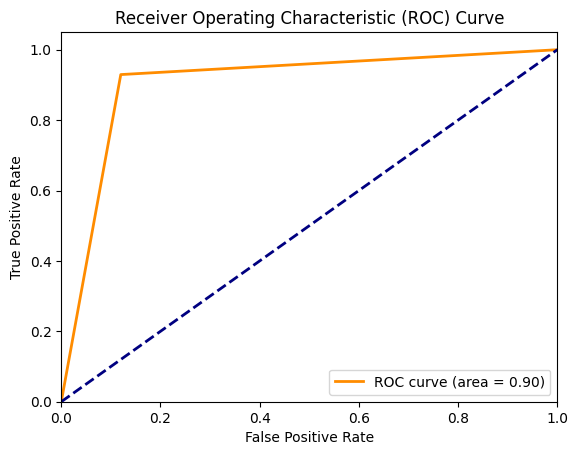

In [ ]:
# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()